# Analiza vegetacije

Satelitski posentki omogočajo pogosto opazovanje velikih površin. Opazujemo lahko stanje in pojave na površju, pri čemer se pogosto usmerjamo na vegetacijo. Staneje vegetacije lahko analiziramo z uporabo podatkov v vidnem in inradrečem delu elektromagnetnega spektra. Satelit Sentinel-2 ima več kanalov, ki so še posebej primerni za spremljanje raslinja.

| Sentinel-2 kanal             | Valovna dolžina (µm) | Ločljivost (m) | Širina kanala (nm) |
|------------------------------|----------------------|----------------|--------------------|
| Band 1 – Coastal aerosol     | 0.443                | 60             | 27/45 (2A/2B)      |
| Band 2 – Blue                | 0.490                | 10             | 98                 |
| Band 3 – Green               | 0.560                | 10             | 45/46 (2A/2B)      |
| Band 4 – Red                 | 0.665                | 10             | 38/39 (2A/2B)      |
| Band 5 – Vegetation Red Edge | 0.705                | 20             | 19/20 (2A/2B)      |
| Band 6 – Vegetation Red Edge | 0.740                | 20             | 18                 |
| Band 7 – Vegetation Red Edge | 0.783                | 20             | 28                 |
| Band 8 – NIR                 | 0.842                | 10             | 115                |
| Band 8A – Narrow NIR         | 0.865                | 20             | 20                 |
| Band 9 – Water vapour        | 0.945                | 60             | 20                 |
| Band 10 – SWIR – Cirrus      | 1.375                | 60             | 20                 |
| Band 11 – SWIR               | 1.610                | 20             | 90                 |
| Band 12 – SWIR               | 2.190                | 20             | 180                |

## Normiran diferencialni vegetacijski indeks NDVI

Ko želimo opisati stanje vegetacije najpogosteje uporabimo normiran diferencialni vegetacijski indeks NDVI. NDVI je bil razvit za opazovanje stanja vegetacije na večjih območjih, na primer na kontinentih ali na celotni Zemlji. NDVI
predstavlja razmerje med razliko infrardečega in rdečega kanala in njuno vsoto:

$$NDVI = \frac{NIR - R}{NIR + R} = \frac{Band_8 - Band_4}{Band_8 + Band_4}$$

Indeks NDVI zavzame vrednosti med −1 in +1, pri čemer višje vrednosti pomenijo bolj intenzivno vegetacijo.

In [1]:
# Potrebne knjižnice
import numpy as np
import matplotlib.pyplot as plt
import glob
from osgeo import gdal
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Velikost grafikonov
plt.rcParams['figure.figsize'] = [12, 8]

## Branje podatkov

Posamezni kanali satelitskih posnetkov Sentinel-2 so v zapisu JPEG2000. Sam format je sicer zelo zapleten, poleg kanalov v različnih ločljivostih vsebuje tudi metapodatke, in je dobro dokumentiran [Sentinel-2 MSI User Guides](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats).

Format JPEG2000 je podprt v navoejših različicah knjižnice GDAL. Preberemo jih v matriko NumPy.

In [4]:
# Mapa s podatki
data_folder = "./posnetki_sub/"

In [5]:
# Seznam posnetkov v mapi
s2_data = glob.glob(data_folder + '*.jp2')

In [6]:
s2_data

['./posnetki_sub/33TVM,2015-07-11,0_B04.jp2',
 './posnetki_sub/33TVM,2015-07-11,0_B08.jp2',
 './posnetki_sub/33TVM,2016-08-14,0_B04.jp2',
 './posnetki_sub/33TVM,2016-08-14,0_B08.jp2',
 './posnetki_sub/33TVM,2017-07-20,0_B04.jp2',
 './posnetki_sub/33TVM,2017-07-20,0_B08.jp2']

In [7]:
# Imena datotek
s2_b4_fn = s2_data[0]
s2_b8_fn = s2_data[1]

In [8]:
# Odpremo datoteki
s2_b4_ds = gdal.Open(s2_b4_fn)
s2_b8_ds = gdal.Open(s2_b8_fn)

## Podatki o posnetku

In [9]:
s2_b8_ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'

In [10]:
s2_b8_ds.GetGeoTransform()

(446000.0, 10.0, 0.0, 5124000.0, 0.0, -10.0)

In [11]:
s2_b8_ds.RasterCount

1

## Preberemo R in IR kanal

In [12]:
# Kanal 4
s2_b4_band = s2_b4_ds.GetRasterBand(1)
# Preberemo v matriko
s2_b4 = s2_b4_band.ReadAsArray().astype(float)
# Vrednost 0 je nan
s2_b4[s2_b4 == 0] = np.nan

In [13]:
# Kanal 8
s2_b8_band = s2_b8_ds.GetRasterBand(1)
# Preberemo v matriko
s2_b8 = s2_b8_band.ReadAsArray().astype(float)
# Vrednost 0 je nan
s2_b8[s2_b8 == 0] = np.nan

## Prikažemo oba kanala

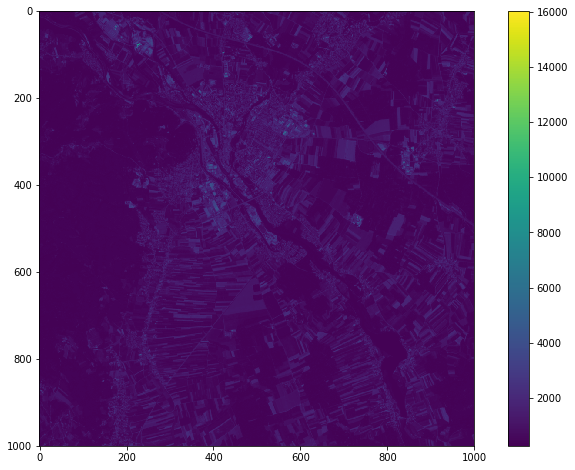

In [14]:
# NIR
plt.imshow(s2_b4)
plt.colorbar()

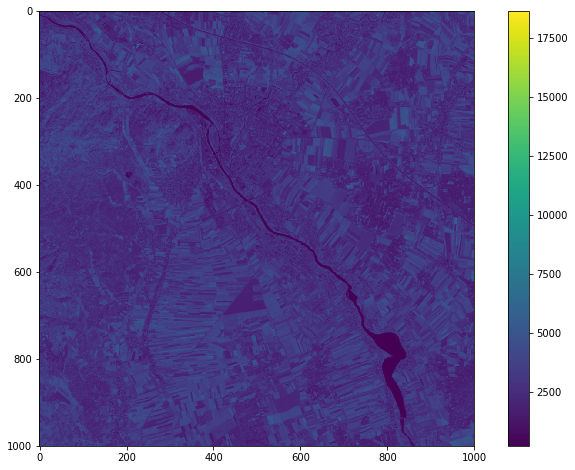

In [15]:
# IR
plt.imshow(s2_b8)
plt.colorbar()

(array([9.63700e+03, 1.82800e+03, 3.20600e+03, 2.33490e+04, 8.81430e+04,
        1.41912e+05, 1.78994e+05, 1.72002e+05, 1.40621e+05, 1.16716e+05,
        7.70940e+04, 3.17160e+04, 1.14380e+04, 2.92900e+03, 3.25000e+02,
        4.10000e+01, 1.70000e+01, 1.20000e+01, 4.00000e+00, 6.00000e+00,
        0.00000e+00, 1.00000e+00, 4.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  239.  ,   606.74,   974.48,  1342.22,  1709.96,  2077.7 ,
         2445.44,  2813.18,  3180.92,  3548.66,  3916.4 ,  4284.14,
         4651.88,  5019.62,  5387.36,  5755.1 ,  6122.84,  6490.58,
         6858.32,  7226.06,  7593.8 ,  7961.54,  8329.28,  8697.

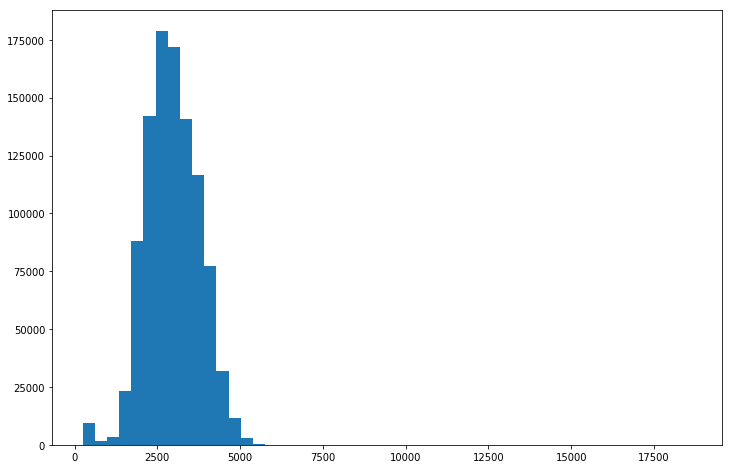

In [16]:
# Histogram kanala 8
plt.hist(s2_b8[~np.isnan(s2_b8)], 50)

In [17]:
s2_b4_flat = s2_b4.flat
s2_b8_flat = s2_b8.flat

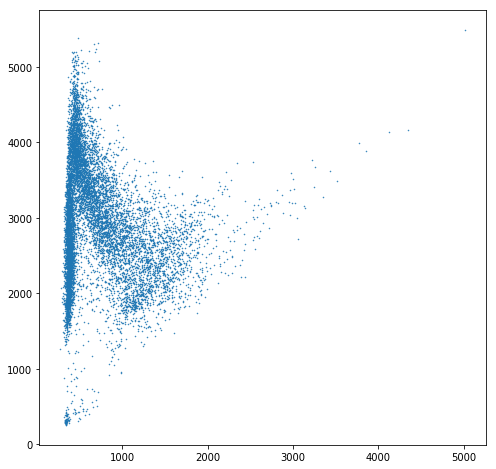

In [18]:
# Decimiramo
idx = np.random.choice(np.arange(len(s2_b4_flat)), 10000, replace=False)
s2_b4_sample = s2_b4.flat[idx]
s2_b8_sample = s2_b8.flat[idx]
# Razsevni diagram
plt.figure(figsize=(8,8))
plt.scatter(s2_b4_sample, s2_b8_sample, marker=".", s=1)
plt.show()

## Izračunajmo NDVI

Za prenešene posnetke izračunamo NDVI. Upoštevali bomo rdeči (4) in infrardeči kanal (8). Če imamo masko podatkov, lahko upoštevamo tudi manjkajoče podatke. NumPy obvlada deljenje z 0 (vrne ni vrednosti, to je `np.nan`), lahko pa matriki dodamo masko ali pa manjkajoče vrednsoti označimo sami.

In [19]:
# Definirajmo funkcijo NDVI
def ndvi(red, nir):
    """Calculate NDVI."""
    return (nir - red) / (nir + red)

In [20]:
# Kanala pretvorimo v float
s2_b4_f = s2_b4.astype(float)
s2_b8_f = s2_b8.astype(float)

In [21]:
s2_ndvi = ndvi(s2_b4_f, s2_b8)

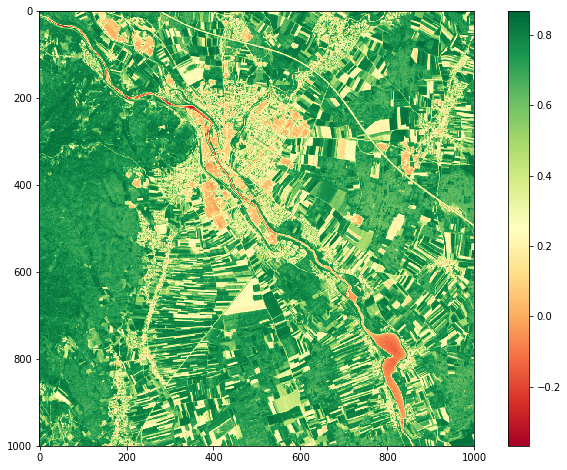

In [22]:
# NDVI
plt.imshow(s2_ndvi, cmap='RdYlGn')
plt.colorbar()

(array([6.00000e+00, 1.30000e+01, 1.40000e+01, 2.50000e+01, 5.20000e+01,
        7.80000e+01, 7.90000e+01, 1.50000e+02, 2.27000e+02, 6.24000e+02,
        1.18300e+03, 1.36100e+03, 1.40900e+03, 1.52200e+03, 1.94100e+03,
        2.94000e+03, 4.99100e+03, 5.78800e+03, 6.01300e+03, 6.44300e+03,
        8.69400e+03, 9.60600e+03, 1.06650e+04, 1.69590e+04, 1.95120e+04,
        1.84160e+04, 1.61760e+04, 1.51320e+04, 1.43450e+04, 1.39590e+04,
        1.44960e+04, 1.52150e+04, 1.52110e+04, 1.62090e+04, 1.72940e+04,
        1.82230e+04, 1.97980e+04, 2.16250e+04, 2.37440e+04, 2.71740e+04,
        3.53230e+04, 4.58870e+04, 5.90710e+04, 7.36920e+04, 8.71580e+04,
        9.94290e+04, 1.03848e+05, 8.92000e+04, 3.62510e+04, 2.82900e+03]),
 array([-0.36814621, -0.3434253 , -0.31870438, -0.29398347, -0.26926255,
        -0.24454163, -0.21982072, -0.1950998 , -0.17037888, -0.14565797,
        -0.12093705, -0.09621613, -0.07149522, -0.0467743 , -0.02205339,
         0.00266753,  0.02738845,  0.05210936,  0

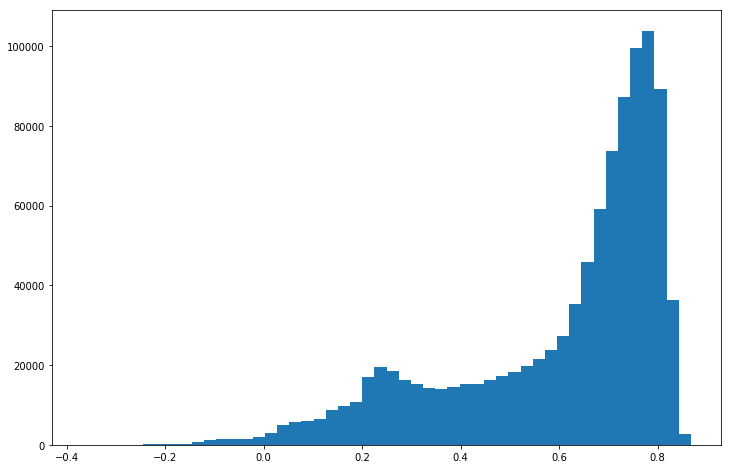

In [23]:
# Histogram
plt.hist(s2_ndvi[~np.isnan(s2_ndvi)], 50)

## Shranimo NDVI v datoteko

In [24]:
# Ime datoteke
s2_ndvi_fn = s2_b4_fn[:-7] + "NDVI.tif"

In [25]:
driver = gdal.GetDriverByName('GTiff')
ndvi_dataset = driver.Create(s2_ndvi_fn,
                             s2_b4_ds.RasterXSize,    # stolpcev
                             s2_b4_ds.RasterYSize,    # vrstic
                             1,                 # kanalov
                             gdal.GDT_Float32)  # tip podatkov
ndvi_dataset.SetProjection(s2_b4_ds.GetProjection())
ndvi_dataset.SetGeoTransform(s2_b4_ds.GetGeoTransform())

# no data je -1
ndvi_band = ndvi_dataset.GetRasterBand(1)
ndvi_band.SetNoDataValue(-1)

# And finally, let's write our NDVI array.
ndvi_band.WriteArray(s2_ndvi)

0

## Določitev območij vegetacije

Najprej določimo prag za vegetacijo, nato izdelamo masko samo vegetacije.

In [26]:
ndvi_tr = 0.2

In [27]:
s2_veg = np.copy(s2_ndvi)
s2_veg[s2_ndvi >= ndvi_tr] = 1
s2_veg[s2_ndvi < ndvi_tr] = 0

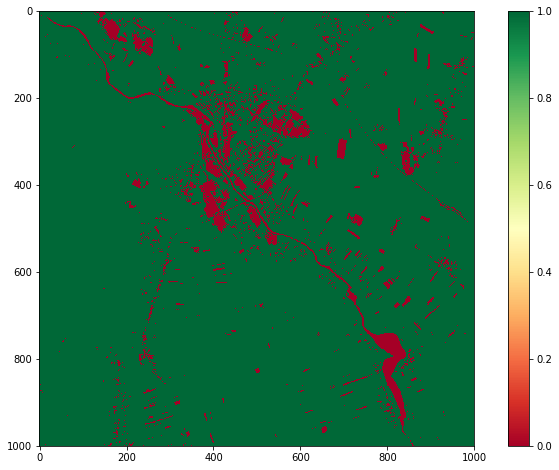

In [28]:
# Prikaz maske vegetacije
plt.imshow(s2_veg, cmap='RdYlGn')
plt.colorbar()